# A First Look at the Data

In [19]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [20]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [21]:
last_skywalker = np.array([0.98, 0.9, -.9])

In [22]:
user1 = np.array([0.9, .8, -.6])

In [23]:
(user1 * last_skywalker).sum()

2.1420000000000003

In [24]:
casablanca = np.array([-.99, -.3, .8])

In [25]:
np.dot(user1.T, casablanca)

-1.611

# Learning the Latent Factors

step 1 : we first initialize some latent factors for user and movie.
step 2: then we dotproduct the latent user factor and movie factor
step 3: then optimize

In [26]:
# Creating the Data Loaders

In [27]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [28]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [29]:
dls = CollabDataLoaders.from_df(ratings, item_name = 'title', bs = 64)
dls.show_batch()

,user,title,rating
0,216,Raising Arizona (1987),5
1,293,Heathers (1989),3
2,682,Dumb & Dumber (1994),3
3,178,Casablanca (1942),4
4,707,Clueless (1995),4
5,7,"Howling, The (1981)",4
6,330,Restoration (1995),4
7,450,Sabrina (1995),4
8,514,Henry V (1989),5
9,727,Star Trek VI: The Undiscovered Country (1991),4


In [30]:
dls.classes['user']

['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

In [37]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(4, 5)
movie_factors = torch.randn(4, 5)

In [58]:
onehot = one_hot(2, 4).float()
onehot

tensor([0., 0., 1., 0.])

In [56]:
user_factors.t()

tensor([[ 0.8040, -0.7330,  0.1510, -0.3133],
        [-0.4623, -0.0891,  1.0304, -0.4805],
        [ 1.3366, -0.7438,  0.6838,  0.6713],
        [-0.5292,  1.2452,  1.5017, -1.0529],
        [-0.1335,  1.2956, -1.2188, -0.5543]])

In [59]:
user_factors.t() @ onehot

tensor([ 0.1510,  1.0304,  0.6838,  1.5017, -1.2188])

In [61]:
user_factors[2]

tensor([ 0.1510,  1.0304,  0.6838,  1.5017, -1.2188])

In [68]:
user_factors.t() @ tensor([0, 0, 1, 0], dtype=float)

tensor([ 0.1510,  1.0304,  0.6838,  1.5017, -1.2188])

In [71]:
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [72]:
one_hot_3 = one_hot(3, n_users).float()

In [73]:
user_factors.t() @ one_hot_3

tensor([-0.0879,  0.4302,  0.1135, -1.5191, -0.2045])

In [74]:
user_factors[3]

tensor([-0.0879,  0.4302,  0.1135, -1.5191, -0.2045])

# Collaborative filtering from scratch

In [93]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_fatcors):
        self.user_factors, self.movie_factors = Embedding(n_users, n_factors), Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        
        return (users * movies).sum(dim=1)

In [94]:
a = Embedding(n_users, n_factors)

In [102]:
x, y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [105]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [106]:
learn.fit_one_cycle(4, 5e-3)

epoch,train_loss,valid_loss,time
0,2.839450,2.576296,00:08
1,1.114095,1.096618,00:08
2,0.968220,0.997219,00:08
3,0.941194,0.985699,00:08


In [107]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_fatcors, y_range=(0, 5.5)):
        self.user_factors, self.movie_factors = Embedding(n_users, n_factors), Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [109]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit(4, 5e-3)

epoch,train_loss,valid_loss,time
0,0.984591,0.965288,00:07
1,0.889515,0.928290,00:07
2,0.853831,0.899244,00:07
3,0.810383,0.881511,00:07


In [110]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [111]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit(4, 5e-3)

epoch,train_loss,valid_loss,time
0,0.961846,0.952292,00:07
1,0.894441,0.906328,00:07
2,0.891460,0.888068,00:07
3,0.820710,0.881303,00:07


In [134]:
x[:, 0]

tensor([833, 508,  92, 684, 295, 336, 548, 409,  70, 601, 654, 269, 130, 642,
        223, 267, 346, 496, 936, 592, 551, 776, 298, 643, 158, 389, 731, 478,
        169,  87, 569, 660, 716,  38, 256, 682, 344, 116, 881, 886, 254, 881,
        901, 797, 109, 165, 204, 291,  82, 682, 334, 442, 295, 934, 554, 620,
        923, 437, 908, 679,  59, 506, 385, 586], device='cuda:0')

In [138]:
n_movies

1665

In [140]:
u_ = Embedding(n_users, 5)
m_ = Embedding(n_movies, 5)
u_(to_cpu(x[:,0][0]))

tensor([-0.0107, -0.0004, -0.0044,  0.0172, -0.0126],
       grad_fn=<EmbeddingBackward>)

# Weight decay | L2 regularization

In [141]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.933619,0.944595,00:09
1,0.865181,0.868031,00:09
2,0.743684,0.824765,00:09
3,0.608659,0.809918,00:09
4,0.470231,0.810171,00:09


# Creating our own Embedding Module

In [151]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [152]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [153]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.944698,0.936422,00:10
1,0.851103,0.865043,00:10
2,0.735562,0.828065,00:10
3,0.554000,0.810728,00:10
4,0.497918,0.811373,00:10


# Interpreting embeddings and biases

In [154]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Robocop 3 (1993)',
 'Island of Dr. Moreau, The (1996)',
 'Striptease (1996)']

In [157]:
movie_bias.argsort()

tensor([ 850,  295, 1251,  ...,  830, 1318, 1501], device='cuda:0')

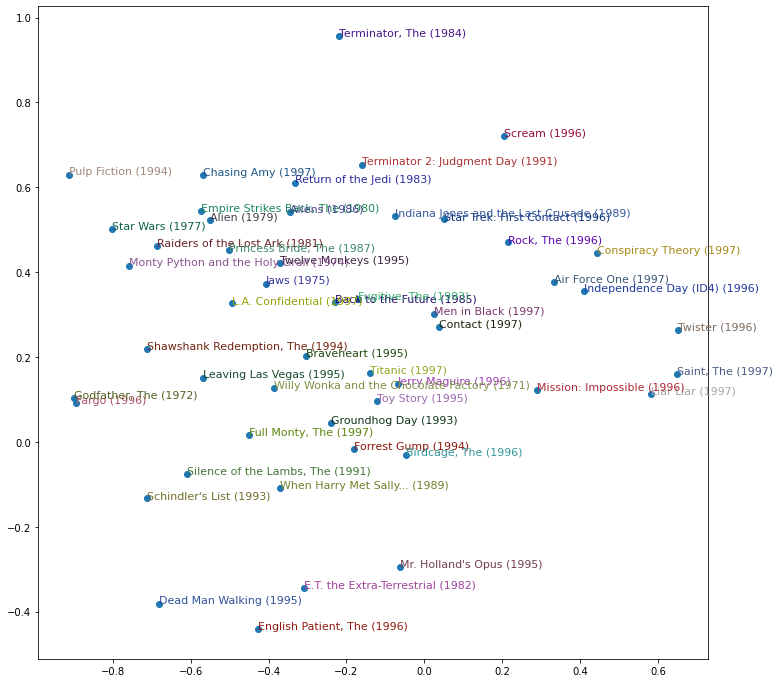

In [161]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Using fastai.collab

In [162]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5)
                      )

In [163]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.925896,0.935540,00:09
1,0.875362,0.863509,00:09
2,0.725499,0.822341,00:09
3,0.591795,0.808800,00:09
4,0.493447,0.809745,00:09


In [165]:
learn.model.parameters

<bound method Module.parameters of EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)>

In [167]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Right Stuff, The (1983)'

# dl for collab

In [168]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [169]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [170]:
model = CollabNN(*embs)

In [171]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.961158,0.950366,00:11
1,0.914244,0.901699,00:10
2,0.864222,0.870794,00:10
3,0.805462,0.850394,00:10
4,0.784827,0.853252,00:11


In [180]:
learn.model.parameters

<bound method Module.parameters of CollabNN(
  (user_factors): Embedding(944, 74)
  (item_factors): Embedding(1665, 102)
  (layers): Sequential(
    (0): Linear(in_features=176, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)>

In [181]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.970648,0.956773,00:13
1,0.908617,0.915897,00:12
2,0.864189,0.874535,00:12
3,0.837212,0.849167,00:12
4,0.751458,0.849072,00:12


In [183]:
x, y = dls.one_batch()

In [185]:
x[1], y[1]

(tensor([244, 401], device='cuda:0'),
 tensor([5], device='cuda:0', dtype=torch.int8))